# Trabalho final de DM

### Davi Oliveira Francisco
#### Matricula: 231101072

# Importando bibliotecas, definindo funções auxiliares

In [7]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns
import numpy as np
import missingno as msno
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import GridSearchCV
from imblearn.over_sampling import SMOTE
from sklearn.svm import SVC
from sklearn.impute import SimpleImputer
import optuna
seed = 1

In [8]:
# Configurando pandas para exibir todas as colunas dos DataFrames
pd.set_option('display.max_columns', None)

In [9]:
def convert_columns_to_numeric(df, columns_to_convert):
    """
    Convert specified columns of a DataFrame to numeric types.
    
    Parameters:
    - df: The DataFrame containing the columns to be converted.
    - columns_to_convert: A list of column names in the DataFrame that should be converted to numeric types.
    
    Returns:
    - A copy of the original DataFrame with the specified columns converted to numeric types.
    """
    for column in columns_to_convert:
        # Attempt to convert each specified column to numeric, coerce errors to NaN
        df[column] = pd.to_numeric(df[column], errors='coerce')
    return df

def missing_analysis(data):

    """
    This function returns the missing data % for each column from the DataFrame taken.

    Parameters:
    - data: Original DataFrame.
    """

    nm_missing = data.isna().sum().sort_values(ascending=False)
    perc_msg = nm_missing/data.shape[0]*100

    return perc_msg

def good_data(data,threshold = 50):

    """
    Returns two things:
     1- a copy of the provided DataFrame considering only the columns that have more than threshold% of data filled.
     2- the list of the columns removed for debug.

    Parameters:
    - data: Original DataFrame.
    - threshold: Minimum percentage of completed data.
    """

    perc_msg = missing_analysis(data)
    good_idx = perc_msg[perc_msg < 50].index
    data_good = data[good_idx].copy()

    removed_data = perc_msg[perc_msg > 50].index

    return data_good,removed_data

def avaliar_modelo(modelo, X_test, y_test):
    """
    Função para calcular a acurácia de um modelo de classificação e plotar a matriz de confusão.

    Parâmetros:
        modelo: modelo de classificação treinado.
        X_test: conjunto de dados de teste (features).
        y_test: labels verdadeiras dos dados de teste.

    Retorna:
        acuracia: a acurácia do modelo nos dados de teste.
    """
    # Fazendo previsões com o modelo nos dados de teste
    y_pred = modelo.predict(X_test)
    
    # Calculando a acurácia
    acuracia = accuracy_score(y_test, y_pred)

    #Printando acurácia
    print(f"Acurácia do modelo: {acuracia*100:.2f}%")
    
    # Calculando a matriz de confusão
    cm = confusion_matrix(y_test, y_pred)
    
    # Plotando a matriz de confusão
    fig, ax = plt.subplots(figsize=(8, 6))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=modelo.classes_)
    disp.plot(cmap='Blues', ax=ax)
    ax.set_title('Matriz de Confusão')
    plt.show()
    
    return 

# EDA

### Importando dados de treino

In [10]:
data = pd.read_excel("Datasets/horse.xlsx")
data.head()

,surgery,age,hospital_number,rectal_temp,pulse,respiratory_rate,temp_of_extremities,peripheral_pulse,mucous_membrane,capillary_refill_time,pain,peristalsis,abdominal_distention,nasogastric_tube,nasogastric_reflux,nasogastric_reflux_ph,rectal_exam_feces,abdomen,packed_cell_volume,total_protein,abdomo_appearance,abdomo_protein,outcome,surgical_lesion,lesion_1,lesion_2,lesion_3,cp_data
0,no,adult,530101,38.5,66.0,28.0,cool,reduced,NaN,more_3_sec,extreme_pain,absent,severe,NaN,NaN,NaN,decreased,distend_large,45,2024-04-08 00:00:00,NaN,NaN,died,no,11300,0,0,no
1,yes,adult,534817,39.2,88.0,20.0,NaN,NaN,pale_cyanotic,less_3_sec,mild_pain,absent,slight,NaN,NaN,NaN,absent,other,50,85,cloudy,2,euthanized,no,2208,0,0,no
2,no,adult,530334,38.3,40.0,24.0,normal,normal,pale_pink,less_3_sec,mild_pain,hypomotile,none,NaN,NaN,NaN,normal,normal,33,2024-07-06 00:00:00,NaN,NaN,lived,no,0,0,0,yes
3,yes,young,5290409,39.1,164.0,84.0,cold,normal,dark_cyanotic,more_3_sec,depressed,absent,severe,none,less_1_liter,5,decreased,NaN,48,2024-02-07 00:00:00,serosanguious,2024-03-05 00:00:00,died,yes,2208,0,0,yes
4,no,adult,530255,37.3,104.0,35.0,NaN,NaN,dark_cyanotic,more_3_sec,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,74,2024-04-07 00:00:00,NaN,NaN,died,no,4300,0,0,no


### Importando dados de teste

In [11]:
data_test = pd.read_excel("Datasets/horseTest.xlsx")

### Dimensões e tipos de dados

In [12]:
data.shape

(299, 28)

In [13]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 299 entries, 0 to 298
Data columns (total 28 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   surgery                299 non-null    object 
 1   age                    299 non-null    object 
 2   hospital_number        299 non-null    int64  
 3   rectal_temp            239 non-null    float64
 4   pulse                  275 non-null    float64
 5   respiratory_rate       241 non-null    float64
 6   temp_of_extremities    243 non-null    object 
 7   peripheral_pulse       230 non-null    object 
 8   mucous_membrane        252 non-null    object 
 9   capillary_refill_time  267 non-null    object 
 10  pain                   244 non-null    object 
 11  peristalsis            255 non-null    object 
 12  abdominal_distention   243 non-null    object 
 13  nasogastric_tube       195 non-null    object 
 14  nasogastric_reflux     193 non-null    object 
 15  nasoga

## Verificando balanceamento das classes nos dados de treino

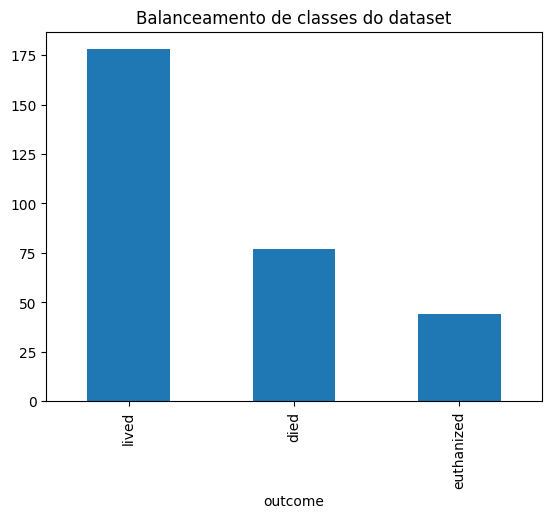

In [14]:
data.outcome.value_counts().plot(kind="bar")
plt.title("Balanceamento de classes do dataset")
plt.show()

## Grande desbalanceamento observado. Será realizado o tratamento posteriormente

## Explorando condições de missing no dataset

Text(0.5, 1.0, 'Matriz de missing no dataset original')

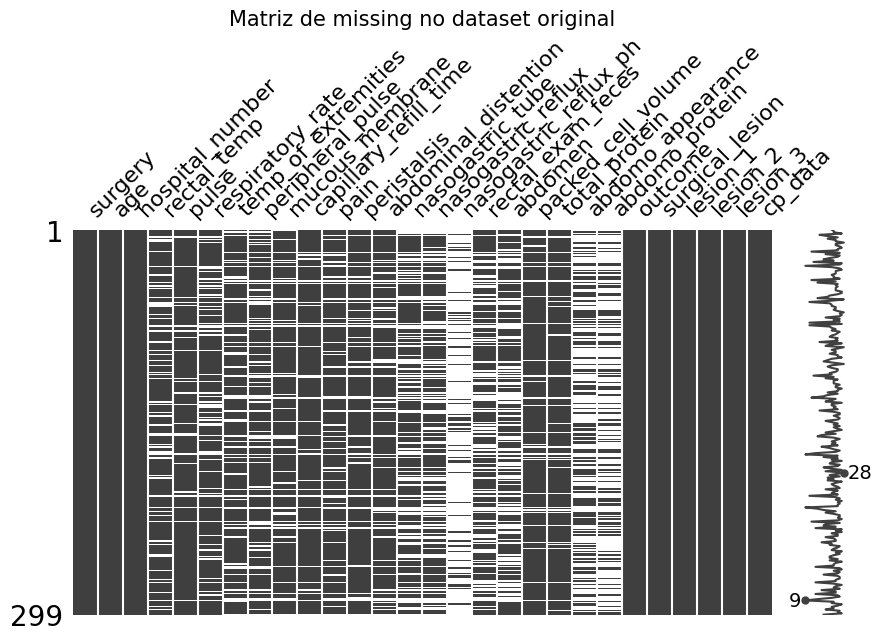

In [15]:
msno.matrix(data,figsize = (10,5))
plt.title("Matriz de missing no dataset original",fontsize = 15)

# Transformando dados numéricos e retirando atributos (colunas) com muitos dados faltantes (50%)

In [16]:
data_model = convert_columns_to_numeric(data,["total_protein","rectal_temp","respiratory_rate","packed_cell_volume","pulse"])

In [17]:
missing_analysis(data_model)

nasogastric_reflux_ph    82.274247
abdomo_protein           66.220736
total_protein            63.210702
abdomo_appearance        55.183946
abdomen                  39.464883
nasogastric_reflux       35.451505
nasogastric_tube         34.782609
rectal_exam_feces        34.113712
peripheral_pulse         23.076923
rectal_temp              20.066890
respiratory_rate         19.397993
temp_of_extremities      18.729097
abdominal_distention     18.729097
pain                     18.394649
mucous_membrane          15.719064
peristalsis              14.715719
capillary_refill_time    10.702341
packed_cell_volume       10.033445
pulse                     8.026756
lesion_2                  0.000000
surgical_lesion           0.000000
lesion_3                  0.000000
lesion_1                  0.000000
surgery                   0.000000
outcome                   0.000000
age                       0.000000
hospital_number           0.000000
cp_data                   0.000000
dtype: float64

In [18]:
data_model_good, removed = good_data(data_model)

### Dados removidos com mais de 50% de dados faltantes

In [19]:
removed

Index(['nasogastric_reflux_ph', 'abdomo_protein', 'total_protein',
       'abdomo_appearance'],
      dtype='object')

# Tratamento de missing de dados numéricos

In [20]:
colunas_numericas = list(data_model_good.select_dtypes(include = ["number"]).columns)
colunas_numericas

['rectal_temp',
 'respiratory_rate',
 'packed_cell_volume',
 'pulse',
 'lesion_2',
 'lesion_3',
 'lesion_1',
 'hospital_number']

In [21]:
medianas = data_model_good[colunas_numericas].median()

data_model_good[colunas_numericas] = data_model_good[colunas_numericas].fillna(medianas)

In [22]:
data_model_good.head(2)

,abdomen,nasogastric_reflux,nasogastric_tube,rectal_exam_feces,peripheral_pulse,rectal_temp,respiratory_rate,temp_of_extremities,abdominal_distention,pain,mucous_membrane,peristalsis,capillary_refill_time,packed_cell_volume,pulse,lesion_2,surgical_lesion,lesion_3,lesion_1,surgery,outcome,age,hospital_number,cp_data
0,distend_large,NaN,NaN,decreased,reduced,38.5,28.0,cool,severe,extreme_pain,NaN,absent,more_3_sec,45.0,66.0,0,no,0,11300,no,died,adult,530101,no
1,other,NaN,NaN,absent,NaN,39.2,20.0,NaN,slight,mild_pain,pale_cyanotic,absent,less_3_sec,50.0,88.0,0,no,0,2208,yes,euthanized,adult,534817,no


### Verificando que todas as colunas numéricas foram preenchidas

In [23]:
missing_analysis(data_model_good[colunas_numericas])

rectal_temp           0.0
respiratory_rate      0.0
packed_cell_volume    0.0
pulse                 0.0
lesion_2              0.0
lesion_3              0.0
lesion_1              0.0
hospital_number       0.0
dtype: float64

# Tratamento de missing de dados categóricos

In [24]:
colunas_object= list(data_model_good[[coluna for coluna in data_model_good.columns if coluna not in colunas_numericas and coluna != "outcome"]].columns)
colunas_object

['abdomen',
 'nasogastric_reflux',
 'nasogastric_tube',
 'rectal_exam_feces',
 'peripheral_pulse',
 'temp_of_extremities',
 'abdominal_distention',
 'pain',
 'mucous_membrane',
 'peristalsis',
 'capillary_refill_time',
 'surgical_lesion',
 'surgery',
 'age',
 'cp_data']

## Preencher os valores faltantes das colunas com o valor da MODA de cada coluna

In [25]:
for coluna in colunas_object:
    data_model_good[coluna] = data_model_good[coluna].fillna(data_model_good[coluna].mode()[0])

## Verificando se os dados foram preenchidos nas colunas de dados categóricos

In [26]:
missing_analysis(data_model_good[colunas_object])

abdomen                  0.0
nasogastric_reflux       0.0
nasogastric_tube         0.0
rectal_exam_feces        0.0
peripheral_pulse         0.0
temp_of_extremities      0.0
abdominal_distention     0.0
pain                     0.0
mucous_membrane          0.0
peristalsis              0.0
capillary_refill_time    0.0
surgical_lesion          0.0
surgery                  0.0
age                      0.0
cp_data                  0.0
dtype: float64

# Preparando dados e realizando treinamento antes do balanceamento para visualizar melhoria no desempenho do modelo com o balanceamento

In [27]:
features = data_model_good.drop("outcome",axis=1)
labels = data_model_good.outcome

## Garantir a formatação das colunas categóricas em string para evitar erros no preprocessamento

In [28]:
for coluna in colunas_object:
    features[coluna] = features[coluna].astype(str)

## Codificando as labels usando LabelEncoder para poder ser utilizado no modelo

#### Objeto encoder ficará salvo para realizar a inverse transform posteriormente.

In [29]:
encoder = LabelEncoder()
y_encoded = encoder.fit_transform(labels)

## Criando objeto para preprocessamento dos dados para o modelo
#### Pipeline numérico aplica uma normalização com StandardScaler e SimpleImputer pra preencher dados faltantes com a mediana dos dados de treinamento.
#### Pipeline categorico aplica OneHotEncoder para transformar atributos categóricos em numéricos e SimpleImputer pra preencher dados faltantes com a moda dos dados de treinamento.

#### Com esse objeto o mesmo processo pode ser aplicado as colunas de maneira consistente.

In [30]:
# Filtrar as colunas removidas das listas de colunas
colunas_numericas_filtradas = [col for col in colunas_numericas if col not in removed]
colunas_object_filtradas = [col for col in colunas_object if col not in removed]

# Criação do Pipeline para dados numéricos
pipeline_numerico = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),  # Preenche NaNs com a mediana
    ('scaler', StandardScaler())                   # Normaliza os dados
])

# Criação do Pipeline para dados categóricos
pipeline_categorico = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),  # Preenche NaNs com a moda
    ('encoder', OneHotEncoder(handle_unknown='ignore'))    # Codifica as categorias
])

# Definindo o preprocessador usando ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', pipeline_numerico, colunas_numericas_filtradas),
        ('cat', pipeline_categorico, colunas_object_filtradas)
    ]
)

## Testando com modelo de classificação (RandomForest) treinado em uma base desbalanceada

In [31]:
features_proc = preprocessor.fit_transform(features)

In [32]:
X_train = features_proc
y_train = y_encoded

In [33]:
X_test = preprocessor.transform(data_test.drop('outcome',axis = 1))
y_test = encoder.transform(data_test['outcome'])

In [34]:
clf_model = RandomForestClassifier(min_samples_leaf=5, random_state=42)

In [35]:
clf_model.fit(X_train,y_train)

RandomForestClassifier(min_samples_leaf=5, random_state=42)

Acurácia do modelo: 77.53%


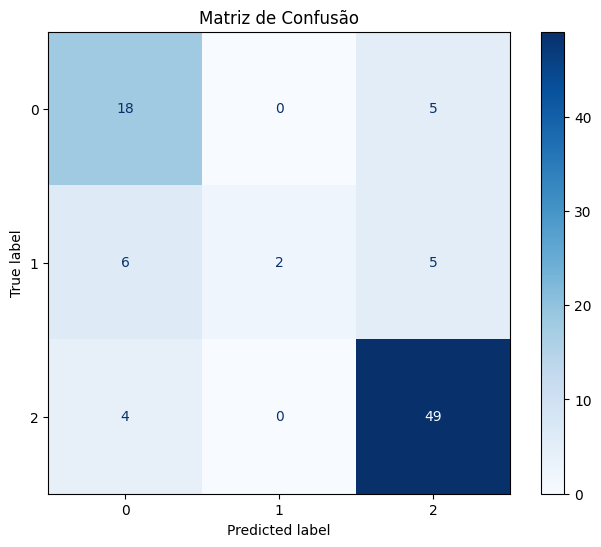

In [36]:
avaliar_modelo(clf_model,X_test,y_test)

### Fica evidente que o modelo performou bem apenas para a classe com mais amostras.

# Realizando balanceamento de dados usando SMOTE e treinando outro modelo

In [37]:
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

In [38]:
series = pd.Series(encoder.inverse_transform(y_train_smote))

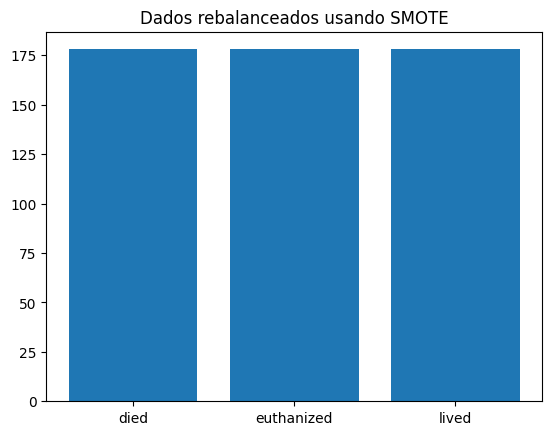

In [39]:
plt.bar(series.unique(),series.value_counts())
plt.title("Dados rebalanceados usando SMOTE")
plt.show()

## Treinando modelo com dados balanceados

In [40]:
clf_model_smote = RandomForestClassifier(min_samples_leaf=5, random_state=42)
clf_model_smote.fit(X_train_smote,y_train_smote)

RandomForestClassifier(min_samples_leaf=5, random_state=42)

Acurácia do modelo: 79.78%


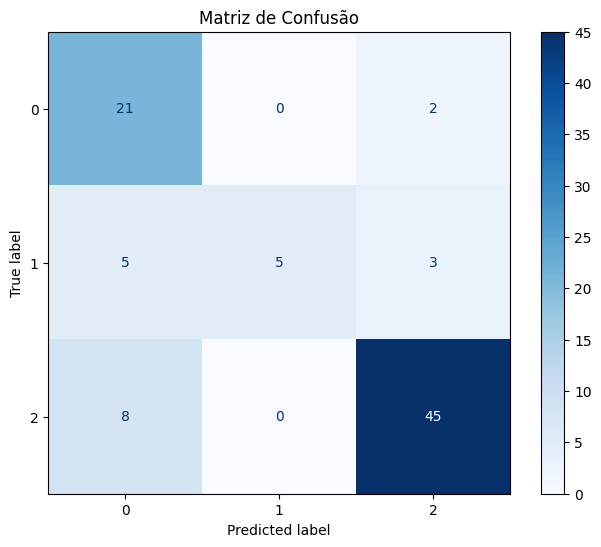

In [41]:
avaliar_modelo(clf_model_smote,X_test,y_test)

## Modelo ainda teve performance relativamente baixa. Para melhorar o resultado será utilizado o método de otimização de parâmetros GridSearchCV.

# Otimização de hiperparametros do modelo treinado com dados balanceados

## Procurando melhor combinação de hiperparâmetros usando GridSearchCV

In [42]:
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
}

grid_search = GridSearchCV(clf_model_smote, param_grid, cv=5, scoring='accuracy')

grid_search.fit(X_train_smote,y_train_smote)

print("Melhores parâmetros:", grid_search.best_params_)
print("Melhor pontuação de cross-validation:", grid_search.best_score_)

Melhores parâmetros: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Melhor pontuação de cross-validation: 0.8989596191147946


## Criando modelo com parametros otimizados

In [43]:
best_model = grid_search.best_estimator_

Acurácia do modelo: 93.26%


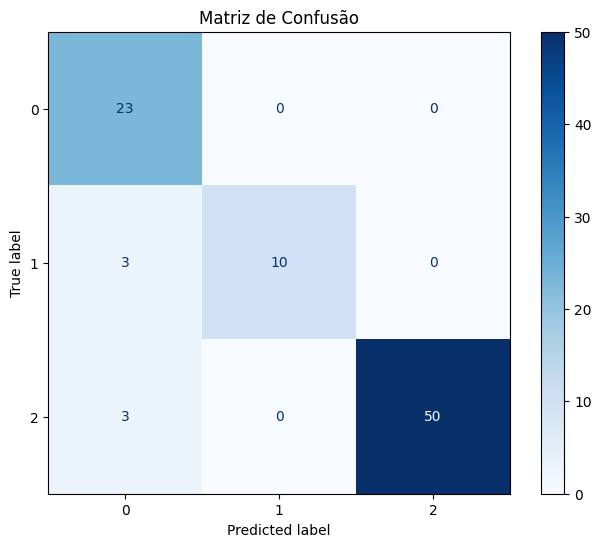

In [44]:
avaliar_modelo(best_model,X_test,y_test)

## A performance do modelo melhorou significativamente.

## Analisando a importancia das features no modelo otimizado de RandomForestClassifier

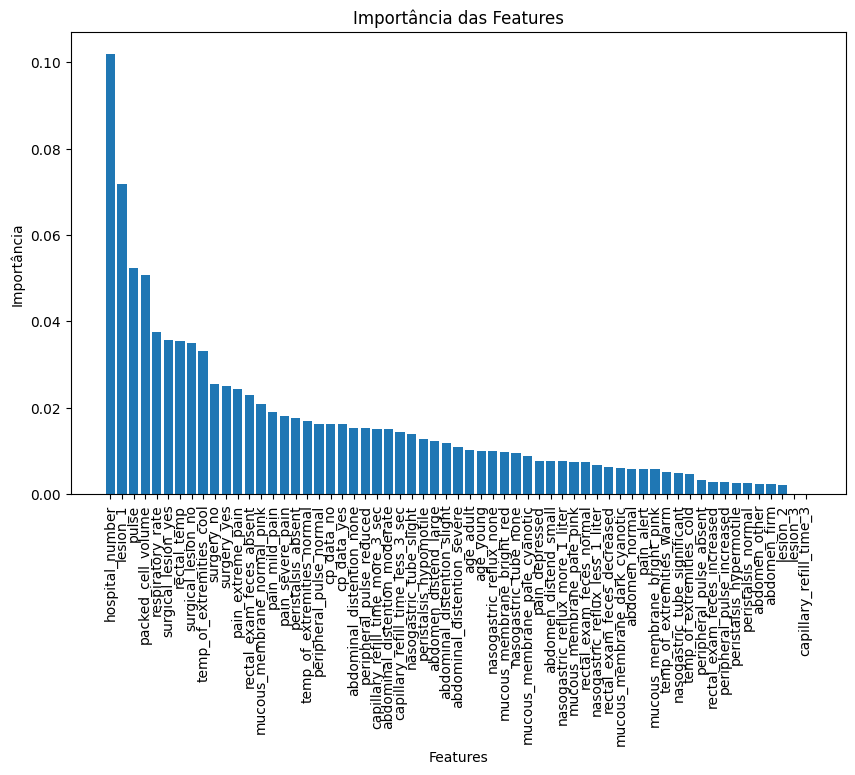

In [45]:
feature_names = colunas_numericas + list(preprocessor.named_transformers_['cat'].get_feature_names_out(colunas_object))

feature_importances = best_model.feature_importances_
indices = np.argsort(feature_importances)[::-1]

plt.figure(figsize=(10, 6))
plt.title('Importância das Features')
plt.bar(range(len(feature_importances)), feature_importances[indices], align='center')
plt.xticks(range(len(feature_importances)), [feature_names[i] for i in indices], rotation=90)
plt.xlabel('Features')
plt.ylabel('Importância')
plt.show()

### OBS: O número do hospital teve grande impacto?!?!?! 
### Outras features menos importantes poderiam ser excluidas mas vamos explorar outras possibilidades de modelos.

# Testando o modelo SVC para comparar com RandomForest

In [46]:
clf_svc = SVC(kernel='rbf', C=1.0, gamma='scale', random_state=42)

In [47]:
clf_svc.fit(X_train_smote,y_train_smote)

SVC(random_state=42)

Acurácia do modelo: 86.52%


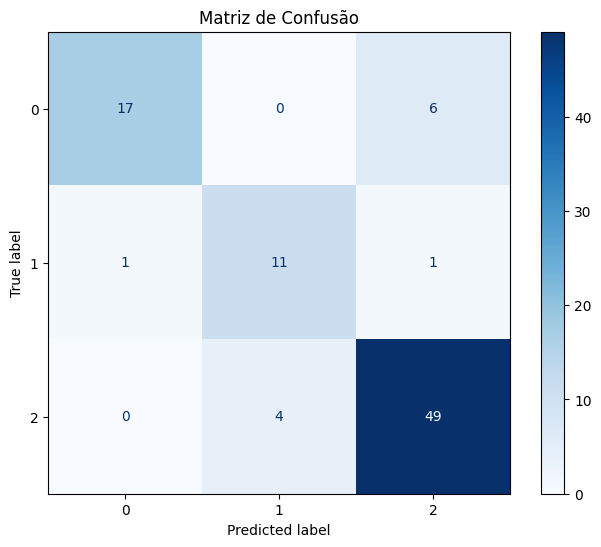

In [48]:
avaliar_modelo(clf_svc,X_test,y_test)

### Performance melhor que o primeiro modelo de RF mas também será otimizado para obter o melhor conjunto de hiperparâmetros.

## Otimização de hiperparâmetros SVC

In [49]:
param_grid_svc = {
    'C': [0.1, 1, 10, 100],  # Regularização
    'kernel': ['linear', 'rbf', 'poly'],  # Tipos de kernel
    'gamma': ['scale', 'auto', 1, 0.1, 0.01, 0.001]  # Coeficiente de kernel para 'rbf', 'poly' e 'sigmoid'
}

grid_search_svc = GridSearchCV(estimator=clf_svc, param_grid=param_grid_svc, cv=5, scoring='accuracy')

grid_search_svc.fit(X_train_smote, y_train_smote)

print("Melhor pontuação:", grid_search_svc.best_score_)
print("Melhores parâmetros:", grid_search_svc.best_params_)



Melhor pontuação: 0.9064186210544877
Melhores parâmetros: {'C': 100, 'gamma': 0.1, 'kernel': 'rbf'}


Acurácia do modelo: 94.38%


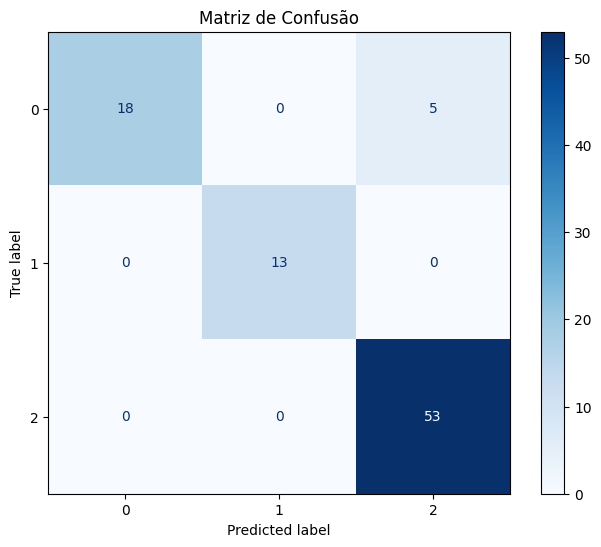

In [50]:
avaliar_modelo(grid_search_svc.best_estimator_,X_test,y_test)

## Os dois modelos obtiveram resultados satisfatórios com mais de 90% de acurácia. 
## Serão gerados arquivos pickle para armazenar os modelos e possiblitar a utilização em um app desenvolvido para previsão.

# Criando objetos de pipeline e labelencoder para utilização no app

In [51]:
pipeline_RF = Pipeline([

    ('preprocessor',preprocessor),
    ('model',best_model)
    
])

pipeline_svc = Pipeline([

    ('preprocessor',preprocessor),
    ('model',grid_search_svc.best_estimator_)
    
])

# Em um arquivo auxiliar.py foi criada a classe MyModel. Nela é possível armazenar as informações do encoder e modelo.
# Serializando (criando pickle) dessa classe é possível prever resultados com o método .predict() dessa nova classe que pega o modelo armazenado e usa para a previsão.
# Além disso, também existe na classe MyModel o método inverse_transform() que utiliza o objeto encoder armazenado para a transformação dos resultados em texto novamente.
# Dessa forma, ao instanciar o objeto vamos fornecer o modelo e encoder correspondente e usando o método .serialize() geramos um pickle do objeto que engloba todos os objetos necessários para usar no app.

# Criando classe para serialização de um único objeto para o app

In [52]:
from auxiliar import MyModel

In [53]:
rf_model = MyModel(pipeline_RF,encoder)
svc_model = MyModel(pipeline_RF,encoder)

In [54]:
rf_model.serialize("rf_model.pkl")
svc_model.serialize("svc_model.pkl")

# Depois de executar todo esse código, é possível rodar o main.py dentro da pasta app e nela realizar o predict por padrão no modelo de SVC ou no outro de RF.